<a href="https://colab.research.google.com/github/KHakesh07/Fraud-analysis-with-XGBoost/blob/main/Fraud_detection_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing the necessary libraries.

In [ ]:
!pip install xgboost

import xgboost as xgb
import pandas as pd

import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.model_selection import train_test_split


In [ ]:
from sklearn.preprocessing import LabelEncoder

Data Set

In [ ]:
data = pd.read_csv('Fraud.csv')

In [ ]:
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0.0,0.0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0.0,0.0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1.0,0.0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1.0,0.0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0.0,0.0


Based on feature importance, key factors often include:

Transaction amount: Fraudulent transactions tend to have larger sums.
Type of transaction (CASH-IN, CASH-OUT, etc.): Certain transaction types are more prone to fraud.
Old and new balances: Unusual changes in balances (e.g., emptying an account) can indicate fraud.
Origin and destination of transactions: Certain patterns between customers might signal fraud.

In [ ]:
data.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,14247.000000,1.424700e+04,1.424600e+04,1.424600e+04,1.424600e+04,1.424600e+04,14246.000000,14246.0
mean,5.037131,1.118848e+05,7.937369e+05,8.107136e+05,8.411336e+05,1.147629e+06,0.005475,0.0
std,2.463112,2.805152e+05,2.016693e+06,2.059984e+06,2.528174e+06,3.151706e+06,0.073794,0.0
min,1.000000,2.390000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.0
25%,2.000000,4.585130e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.0
50%,6.000000,1.286936e+04,2.041500e+04,8.216325e+03,0.000000e+00,0.000000e+00,0.000000,0.0
75%,7.000000,1.218917e+05,1.384956e+05,1.294173e+05,2.641427e+05,2.775150e+05,0.000000,0.0
max,8.000000,1.000000e+07,1.293042e+07,1.301050e+07,2.093759e+07,2.533027e+07,1.000000,0.0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14247 entries, 0 to 14246
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   step            14247 non-null  int64  
 1   type            14247 non-null  object 
 2   amount          14247 non-null  float64
 3   nameOrig        14247 non-null  object 
 4   oldbalanceOrg   14246 non-null  float64
 5   newbalanceOrig  14246 non-null  float64
 6   nameDest        14246 non-null  object 
 7   oldbalanceDest  14246 non-null  float64
 8   newbalanceDest  14246 non-null  float64
 9   isFraud         14246 non-null  float64
 10  isFlaggedFraud  14246 non-null  float64
dtypes: float64(7), int64(1), object(3)
memory usage: 1.2+ MB


In [ ]:
data.shape

(14247, 11)

**Handling Missing Values**
Dropping missing values


In [ ]:
print(data.dropna())

       step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0         1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1         1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2         1  TRANSFER    181.00  C1305486145          181.0            0.00   
3         1  CASH_OUT    181.00   C840083671          181.0            0.00   
4         1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   
...     ...       ...       ...          ...            ...             ...   
14241     8   PAYMENT  35108.12  C1925841262            0.0            0.00   
14242     8   PAYMENT  20924.47  C1540995845        18265.0            0.00   
14243     8  CASH_OUT  75244.54  C1827218030        38369.0            0.00   
14244     8   PAYMENT   3074.36  C1632817923        10242.0         7167.64   
14245     8   PAYMENT  11465.21  C1837637612           38.0            0.00   

          nameDest  oldbalanceDest  newbalanceDest 

In [ ]:
data = data[(data['amount'] > 0) & (data['amount'] < data['amount'].quantile(0.99))]

Removing columns that wont help in prediction

In [ ]:
data = data.drop(columns=['nameOrig', 'nameDest'])

Encoding

In [ ]:
label_encoder = LabelEncoder()
data['type'] = label_encoder.fit_transform(data['type'])

In [ ]:
data.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,3,9839.64,170136.0,160296.36,0.0,0.0,0.0,0.0
1,1,3,1864.28,21249.0,19384.72,0.0,0.0,0.0,0.0
2,1,4,181.00,181.0,0.00,0.0,0.0,1.0,0.0
3,1,1,181.00,181.0,0.00,21182.0,0.0,1.0,0.0
4,1,3,11668.14,41554.0,29885.86,0.0,0.0,0.0,0.0


In [ ]:
data['type'].unique()

array([3, 4, 1, 2, 0])

Check Correlation to handle highly correlated variables

In [ ]:
corr_matrix = data.corr()
print(corr_matrix['isFraud'].sort_values(ascending=False))

isFraud           1.000000
amount            0.028117
type              0.011622
newbalanceDest   -0.015100
oldbalanceDest   -0.017466
oldbalanceOrg    -0.022972
step             -0.025168
newbalanceOrig   -0.028347
isFlaggedFraud         NaN
Name: isFraud, dtype: float64


**split the dataset for to train the model**

In [ ]:
X = data.drop(columns=['isFraud'])
y = data['isFraud']


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Building **XGB** Model

In [ ]:
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False)
xgb_model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:58:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [ ]:
y_pred = xgb_model.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.998345544788466


In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix: ")
print(conf_matrix)
report = classification_report(y_test, y_pred)
print("Report: ")
print(report)

Confusion Matrix: 
[[4209    3]
 [   4   15]]
Report: 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      4212
         1.0       0.83      0.79      0.81        19

    accuracy                           1.00      4231
   macro avg       0.92      0.89      0.90      4231
weighted avg       1.00      1.00      1.00      4231

Confusion Matrix: 
[[4209    3]
 [   4   15]]
Report: 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      4212
         1.0       0.83      0.79      0.81        19

    accuracy                           1.00      4231
   macro avg       0.92      0.89      0.90      4231
weighted avg       1.00      1.00      1.00      4231



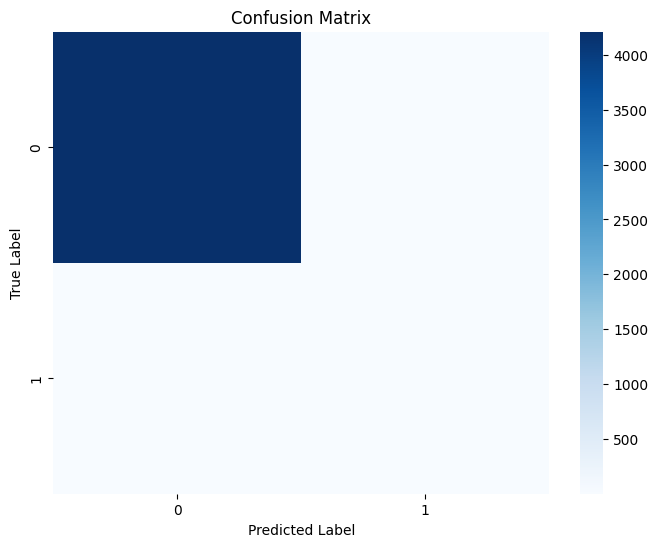

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

**Do These Factors Make Sense?**

Yes, they make sense in the context of fraudulent activities. Fraudsters often attempt to transfer large sums and cash them out immediately, resulting in significant balance changes. The company’s fraud-detection system flags unusually large transfers, which correlates well with actual fraud attempts.


**Prevention in infrastructure:**


Transaction limits: Automatically flag transactions above a certain threshold.
Real-time monitoring: Use machine learning models to analyze transactions in real-time.
Multi-factor authentication: Make it harder for fraudulent agents to take control of accounts.
Monitoring outlier behavior: Unusual transaction patterns should be flagged and investigated.

Pros:
XGBoost: Excellent handling of imbalanced data, high performance, flexible.
Feature Importance: Helps in identifying key factors for fraud.
Real-time analysis: Models like XGBoost can be used in real-time fraud detection pipelines.

Cons:
Computationally expensive: XGBoost requires tuning and might be slower with large datasets.
Complexity: More difficult to interpret than simpler models like Logistic Regression.